In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [4]:
# Path ke direktori dataset
train_dir = './Dataset/for CNN/Saturasi 80'
validation_dir = './Dataset/for CNN/val'

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi nilai pixel
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load data latih
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(80, 80),
    batch_size=64,
    class_mode='categorical'
)

# Load data validasi
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(80, 80),
    batch_size=64,
    class_mode='categorical'
)

Found 1677 images belonging to 5 classes.
Found 160 images belonging to 5 classes.


In [21]:
# Arsitektur CNN
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(80, 80, 3)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(5, activation='softmax')  # 5 kelas untuk klasifikasi tingkat kematangan pisang
])

# Ringkasan model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 78, 78, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,096,389 (4.18 MB)

 Trainable params: 1,096,389 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Optimizer dan compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
#  Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [24]:
# Callbacks Checkpoint
filepath = "./Models/CNN_80.keras"

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                verbose = 1)


callback_list = [checkpoint]

In [25]:
# Melatih model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    callbacks=callback_list)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1902 - loss: 1.6106
Epoch 1: val_loss improved from inf to 1.59573, saving model to ./Models/CNN_80.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.1906 - loss: 1.6106 - val_accuracy: 0.2375 - val_loss: 1.5957
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2309 - loss: 1.6070
Epoch 2: val_loss improved from 1.59573 to 1.57991, saving model to ./Models/CNN_80.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.2311 - loss: 1.6068 - val_accuracy: 0.2000 - val_loss: 1.5799
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2571 - loss: 1.5850
Epoch 3: val_loss improved from 1.57991 to 1.48359, saving model to ./Models/CNN_80.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.2584 - loss: 1.5839 - val_accuracy: 0.4313 - val_loss: 1.4836
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3994 - loss: 1.4845
Epoch 4: val_loss improved from 1.

In [26]:
# Save Model
model.save("./Models/CNN_80.h5")

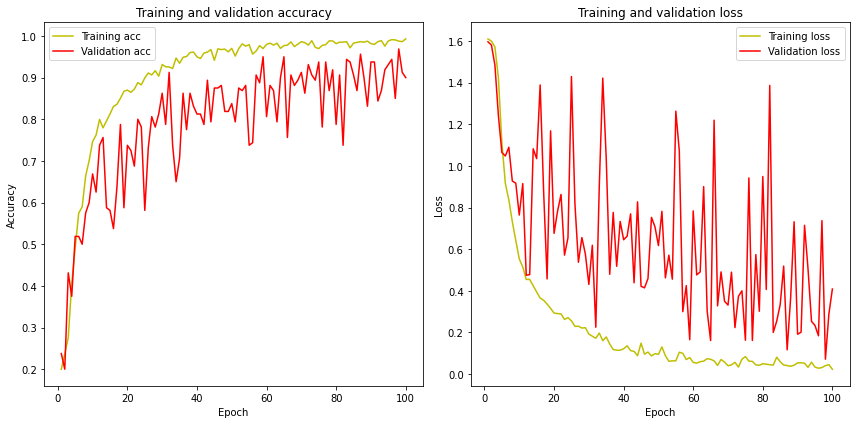

In [27]:
# Plot akurasi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 80 images belonging to 5 classes.


c:\Users\CATUR WARGA COMPUTER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step

Classification Report:

                precision    recall  f1-score   support

         Busuk       1.00      1.00      1.00        16
        Matang       0.79      0.69      0.73        16
        Mentah       1.00      0.94      0.97        16
 Menuju Matang       0.93      0.81      0.87        16
Terlalu Matang       0.76      1.00      0.86        16

      accuracy                           0.89        80
     macro avg       0.90      0.89      0.89        80
  weighted avg       0.90      0.89      0.89        80



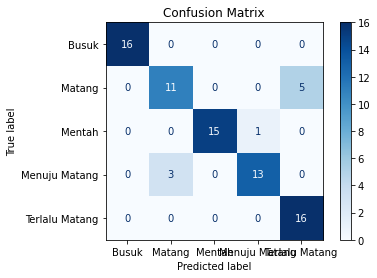

In [37]:
# Path ke model yang disimpan dalam format .h5
model_path = "./Models/CNN_80.h5"

# Memuat model
model = load_model(model_path)

# Path ke direktori dataset uji
test_dir = "./Dataset/for CNN/test"

# Menggunakan ImageDataGenerator untuk memuat dan menormalkan data
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Membuat generator untuk data uji
validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(80, 80),  
    batch_size=64,
    class_mode='categorical',  
    shuffle=False 
)

# Get the true labels from the generator
true_labels = validation_generator.classes

# Predict the classes for the validation data
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy, precision, recall, and f1-score
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='macro')
recall = recall_score(true_labels, predicted_classes, average='macro')
f1_sklearn = f1_score(true_labels, predicted_classes, average='macro')

# Generate and print classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(true_labels, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predictions for ./Dataset/Default/Busuk/IMG_E3890.jpg: Busuk

Confidence result: 
Busuk 	:   1.0
Matang 	:   3.90432e-30
Mentah 	:   1.3318393e-21
Menuju Matang 	:   7.0931022e-28
Terlalu Matang 	:   1.07520445e-13


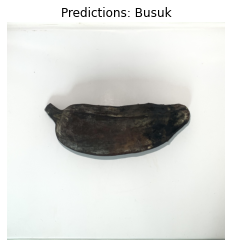

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predictions for ./Dataset/Default/Matang/IMG_2803.JPG: Matang

Confidence result: 
Busuk 	:   2.3299807e-09
Matang 	:   0.99994016
Mentah 	:   3.2450136e-11
Menuju Matang 	:   5.067884e-05
Terlalu Matang 	:   9.153149e-06


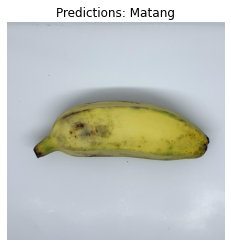

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predictions for ./Dataset/Default/Mentah/1.jpg: Mentah

Confidence result: 
Busuk 	:   1.5244844e-08
Matang 	:   1.5277396e-14
Mentah 	:   0.9999988
Menuju Matang 	:   1.1368107e-06
Terlalu Matang 	:   1.2013627e-09


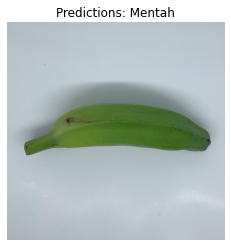

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predictions for ./Dataset/Default/Menuju Matang/IMG_2571.jpg: Menuju Matang

Confidence result: 
Busuk 	:   4.26444e-09
Matang 	:   0.0005185327
Mentah 	:   1.3977969e-07
Menuju Matang 	:   0.9994814
Terlalu Matang 	:   1.24691e-08


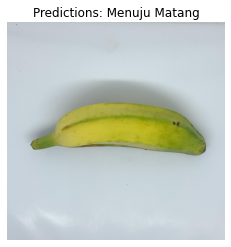

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions for ./Dataset/Default/Terlalu Matang/IMG_3339.jpg: Terlalu Matang

Confidence result: 
Busuk 	:   4.128591e-07
Matang 	:   4.410277e-12
Mentah 	:   1.1632453e-16
Menuju Matang 	:   3.8305382e-16
Terlalu Matang 	:   0.99999964


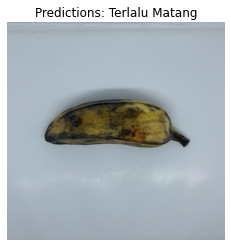

In [43]:
# Load the saved model
model = tf.keras.models.load_model('./Models/CNN_80.keras')

def preprocess_image(img_path):
    # Convert image to RGB format and save as JPEG if needed
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img.save(img_path.replace('.png', '.jpg'), 'JPEG')

    # Load and resize the image
    img = image.load_img(img_path.replace('.png', '.jpg'), target_size=(80, 80))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# List of image paths
img_paths = [
    './Dataset/Default/Busuk/IMG_E3890.jpg',            #Busuk
    './Dataset/Default/Matang/IMG_2803.JPG',            #Matang
    './Dataset/Default/Mentah/1.jpg',                   #Mentah
    './Dataset/Default/Menuju Matang/IMG_2571.jpg',     #Menuju Matang
    './Dataset/Default/Terlalu Matang/IMG_3339.jpg'     #Telalu Matang
]

# Labels for the classes
labels = ['Busuk', 'Matang', 'Mentah', 'Menuju Matang', 'Terlalu Matang']

# Process and predict each image
for img_path in img_paths:
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
    print(f"Predictions for {img_path}: {labels[predicted_index]}")
    
    # Print confidence results for each class
    print("\nConfidence result: ")
    for i, j in enumerate(predictions[0]):
        print(labels[i], "\t:  ", j)
    
    # Display the image with the prediction title
    plt.imshow(image.load_img(img_path.replace('.png', '.jpg')))
    plt.title(f'Predictions: {labels[predicted_index]}')
    plt.axis('off')
    plt.show()